## Load/import packages

In [1]:
from os import listdir
from os.path import splitext
from os.path import join
import skvideo

skvideo.setFFmpegPath(
    r"C:\Users\ion\anaconda3\envs\tf-gpu\Lib\site-packages\ffmpeg-4.3.1-2020-10-01-full_build\bin"
)
import skvideo.io
import json
import cv2

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Functions

In [2]:
# Distribution of classes for training set
def AW2_distplotter(distribution,title, overlay=True):
    # Distribution of class for training set in percentages
    if overlay == True:
        percentages = {name:round((value/sum(distribution.values()))*100,2) for name, value in zip(names_class, distribution.values())}
    
    fig, axes = plt.subplots(figsize=(10,8))
    ax1 = axes.bar(distribution.keys(), distribution.values(), color=('b','g','r','c','m','y','k'))
    axes.set_title(title)
    
    if overlay == True:
        for rect, value in zip(ax1, percentages.values()):
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2, height, f'{height}' , ha='center', va='bottom')
            plt.text(rect.get_x() + rect.get_width()/2, height/1.05, f'{value}%', color='white', ha='center', va='top')

## Explanation of different datasets
The Aff-Wild2 dataset is used for training, validation and testing. While the AFEW 7.0 dataset is only used for testing. 

#### Aff-Wild2
In this dataset all videos are in one folder. Each video has a corresponding .txt file where each frame is annotated with the correspending facial expression class at that frame. In each video multiple emotions are displayed, thats why the annotation is per frame.

In [3]:
from load_filenames import (AW2_dir_train_labels,
                            AW2_dir_val_labels,
                            AW2_dir_allvideos,
                            AW2_train_FN,
                            AW2_train_FN_split,
                            AW2_val_FN,
                            AW2_val_FN_split,
                            AW2_videos_FN,
                            AW2_videos_FN_split)

# Aff-Wild2 Dataset Size

In [4]:
# Size of each set
print(f"The training-set contains: {len(AW2_train_FN)} videos")
print(f"The validation-set contains: {len(AW2_val_FN)} videos")
print(
    f"The test-set contains: {len(AW2_videos_FN) - (len(AW2_train_FN) + len(AW2_val_FN))} videos"
)
print(f"The whole dataset contains: {len(AW2_videos_FN)} videos")

The training-set contains: 253 videos
The validation-set contains: 70 videos
The test-set contains: 225 videos
The whole dataset contains: 548 videos


In [5]:
# Checking if the labeled filenames corresponds to the videos
train_size = 0
for i in AW2_train_FN_split:
    for j in AW2_videos_FN_split:
        if i[0] == j[0]:
            train_size += 1
print(train_size)

246


The results show that only 246 labels are matched to videos, while there were 253 labeled videos. **Some videos contain two persons, so the labels are for one person on the left or right.**

In [6]:
# Checking if the labeled filenames corresponds to the videos (and disregarding if its on left or right)
train_size = 0
for i in AW2_train_FN_split:
    for j in AW2_videos_FN_split:
        if "_left" in i[0]:
            a = i[0].replace("_left", "")
        elif "_right" in i[0]:
            a = i[0].replace("_right", "")
        else:
            a = i[0]
        if a == j[0]:
            train_size += 1
# Labels is equal to videos now
print(f"Training dataset is indeed = {train_size} videos")

# Checking if the labeled filenames corresponds to the videos (and disregarding if its on left or right)
val_size = 0
for i in AW2_val_FN_split:
    for j in AW2_videos_FN_split:
        if "_left" in i[0]:
            a = i[0].replace("_left", "")
        elif "_right" in i[0]:
            a = i[0].replace("_right", "")
        else:
            a = i[0]
        if a == j[0]:
            val_size += 1
# Labels is equal to videos now
print(f"Validation dataset is indeed = {val_size} videos")

Training dataset is indeed = 253 videos
Validation dataset is indeed = 70 videos


# Sequence length of each video

V1 and V2 use the metadata to retreive the amount of frames in each video. While fast, it can be inaccurate sometimes. Thats why I am using V3 to check the videos manually.

### Version 1

In [7]:
# Create dictionary of sequence length of each video with ffprobe in skvideo
AW2_seqlength = {}
AW2_seqlength_without_extension = {}
for video in AW2_videos_FN:
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    framerate = (metadata.get("video").get("@r_frame_rate"))
    frames = int(metadata.get("video").get("@nb_frames"))
    width = int(metadata.get("video").get("@width"))
    height = int(metadata.get("video").get("@height"))
    AW2_seqlength[video] = [frames, height, width, 3]

    name, ext = splitext(video)
    AW2_seqlength_without_extension[name] = [frames, height, width, 3]

In [8]:
AW2_seqlength

{'1-30-1280x720.mp4': [10355, 720, 1280, 3],
 '10-60-1280x720.mp4': [2501, 720, 1280, 3],
 '100-29-1080x1920.mp4': [2639, 1920, 1080, 3],
 '101-30-1080x1920.mp4': [5153, 1920, 1080, 3],
 '102-30-640x360.mp4': [2983, 360, 640, 3],
 '102.avi': [4777, 360, 480, 3],
 '103-30-384x480.mp4': [771, 480, 384, 3],
 '103.avi': [26617, 360, 600, 3],
 '104-17-720x480.mp4': [2425, 480, 720, 3],
 '105-30-1280x720.mp4': [1501, 720, 1280, 3],
 '105.avi': [10076, 360, 640, 3],
 '106-30-720x1280.mp4': [1404, 1280, 720, 3],
 '106.avi': [8163, 360, 480, 3],
 '107-30-640x480.mp4': [73, 480, 640, 3],
 '107.avi': [5315, 360, 640, 3],
 '108-15-640x480.mp4': [478, 480, 640, 3],
 '108.avi': [4678, 360, 640, 3],
 '109-30-1280x720.mp4': [1045, 720, 1280, 3],
 '11-24-1920x1080.mp4': [5389, 1080, 1920, 3],
 '110-30-270x480.mp4': [9978, 480, 270, 3],
 '110.avi': [5504, 360, 640, 3],
 '111-25-1920x1080.mp4': [771, 1080, 1920, 3],
 '111.avi': [7246, 360, 640, 3],
 '112-30-640x360.mp4': [6002, 360, 640, 3],
 '112.avi': 

### Version 2

In [9]:
# Create dictionary of sequence length of each video with ffprobe in skvideo and opencv to capture the amount of frames
AW2_seqlength_V2 = {}

for video in AW2_videos_FN:
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    width = int(metadata.get("video").get("@width"))
    height = int(metadata.get("video").get("@height"))

    cap = cv2.VideoCapture(join(AW2_dir_allvideos, video))
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    AW2_seqlength_V2[video] = [frames, height, width, 3]

In [10]:
# Checking if the video length is the same with each method
AW2_seqlength == AW2_seqlength_V2

True

### Version 3

In [ ]:
# # Create dictionary of sequence length of each video with ffprobe in skvideo and opencv to capture the amount of frames manually
# AW2_seqlength_V3 = {}

# counter = 0
# for video in AW2_videos_FN:
#     print(counter)
#     counter += 1
#     metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
#     width = int(metadata.get("video").get("@width"))
#     height = int(metadata.get("video").get("@height"))

#     frames = count_frames_manual(cv2.VideoCapture(join(AW2_dir_allvideos, video)))
#     AW2_seqlength_V3[video] = [frames, height, width, 3]

In [ ]:
# # Checking if the video length is the same between V1(=V2) and V3
# AW2_seqlength == AW2_seqlength_V3

In [108]:
# for video in AW2_videos_FN:
#     if (AW2_seqlength.get(video) == AW2_seqlength_V3.get(video)) == False:
#         print(
#             video,
#             f"V1: {AW2_seqlength_V2.get(video)} and V3: {AW2_seqlength_V3.get(video)}",
#         )

252.mp4 V1: [2756, 360, 640, 3] and V3: [2755, 360, 640, 3]
video30.mp4 V1: [8217, 1080, 1920, 3] and V3: [8197, 1080, 1920, 3]


**Two videos seem to have less actual frames then the metadata has shown:**

- 252.mp4  
    - V1: [2756, 360, 640, 3]
    - V3: [2755, 360, 640, 3]
- video30.mp4 
    - V1: [8217, 1080, 1920, 3]
    - V3: [8197, 1080, 1920, 3]
***

In [8]:
# Save json file with all video's names and shapes = (n_frames, width, height, colour channels)
with open("AW2_video_shapes.json", "w") as fp:
    json.dump(AW2_seqlength, fp)

## Load the saved video shapes file 

In [11]:
# Load Aff-Wild2 video_shapes.json
with open("AW2_video_shapes.json", "r") as fp:
    AW2_video_shapes = json.load(fp)

## Some Summary statistics about video frames

In [12]:
AW2_all_sequenceslength = [items[0] for items in list(AW2_video_shapes.values())]
print(f'The mean length of all sequences is: {np.mean(AW2_all_sequenceslength)} frames')
print(f'The median length of all sequences is: {np.median(AW2_all_sequenceslength)} frames')
print(f'The SD of length of all sequences is: {np.std(AW2_all_sequenceslength)} frames')

The mean length of all sequences is: 5065.867579908676 frames
The median length of all sequences is: 4355.0 frames
The SD of length of all sequences is: 3859.6255402865236 frames


### Scatterplot of sequence length per resolution

ValueError: x and y must be the same size

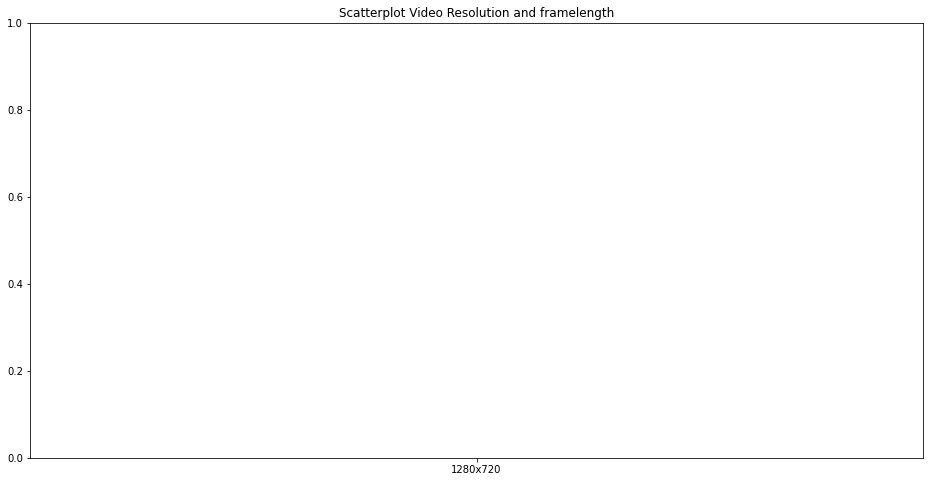

In [17]:
names = [(str(items[2])+"x"+ str(items[1])) for items in list(AW2_seqlength.values())]
fig, axes = plt.subplots(figsize=(16,8))
axes.set_title('Scatterplot Video Resolution and framelength')
axes.scatter(names,  AW2_all_sequenceslength, alpha=0.4)
plt.xticks(rotation=45, ha='right');

In [ ]:
AW2_res_dist = {resolution:names.count(resolution) for resolution in sorted(set(names))}

fig, axes = plt.subplots(figsize=(15,8))
ax1=axes.bar(AW2_res_dist.keys(), AW2_res_dist.values())
axes.set_title('Histogram Video Resolution')
plt.xticks(rotation=45, ha='right')
for rect in ax1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, f'{height}' , ha='center', va='bottom');

## Framerate of each video 

In [ ]:
# Grab the framerate for each video in the Aff-wild2 dataset. 
# Then convert it to avg framerate value in decimals.
AW2_framerates = {}
for video in AW2_videos_FN:
    metadata = skvideo.io.ffprobe(join(AW2_dir_allvideos, video))
    num, denom = (metadata.get("video").get("@avg_frame_rate")).split('/')
    AW2_framerates[video] = (int(num)/int(denom))

In [ ]:
AW2_framerates

In [ ]:
# Put all framerates in a list
AW2_all_framerates = [AW2_framerates.get(video) for video in AW2_videos_FN]

# Count the occurence of each framerate to get the distribution
AW2_framerates_dist = {framerate:AW2_all_framerates.count(framerate) for framerate in sorted(set(AW2_all_framerates))}

In [ ]:
AW2_all_framerates

In [ ]:
AW2_framerates_dist

In [ ]:
fig, axes = plt.subplots(figsize=(15,8))
ax1=axes.bar(AW2_framerates_dist.keys(), AW2_framerates_dist.values())
axes.set_title('Histogram Video Resolution')
for rect in ax1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, f'{height}' , ha='center', va='bottom');

## Classes per video in training and validation set ##

In [14]:
# Load all txt files and create dictionary where each key is the filename and value is all the values (annotations) in the text file
AW2_train_classes = {}
for ann_file in AW2_train_FN:
    with open(join(AW2_dir_train_labels, ann_file), "r") as fp:
        AW2_train_classes[ann_file] = list(map(int,(fp.read().splitlines()[1:]) ))

AW2_val_classes = {}
for ann_file in AW2_val_FN:
    with open(join(AW2_dir_val_labels, ann_file), "r") as fp:
        AW2_val_classes[ann_file] = list(map(int,(fp.read().splitlines()[1:]) ))

In [16]:
# Save json file with all annotations_files and values
with open("AW2_train_classes.json", "w") as fp:
    json.dump(AW2_train_classes, fp)
    
# Save json file with all annotations_files and values
with open("AW2_val_classes.json", "w") as fp:
    json.dump(AW2_val_classes, fp)

In [70]:
# Checking if the lentgh of each text annotated file is the same as the amount of frames in a video.
for ann_file in AW2_train_FN:
    name, ext = splitext(ann_file)
    if "_left" in name:
        name = name.replace("_left", "")
    elif "_right" in name:
        name = name.replace("_right", "")
    x = AW2_seqlength_without_extension.get(name)[0]
    y = len(AW2_train_classes.get(ann_file))
    print([ann_file], f"has {y-x} more annotation than frames")

['1-30-1280x720.txt'] has 1 more annotation than frames
['10-60-1280x720.txt'] has 1 more annotation than frames
['10-60-1280x720_right.txt'] has 1 more annotation than frames
['100-29-1080x1920.txt'] has 1 more annotation than frames
['101-30-1080x1920.txt'] has 1 more annotation than frames
['102-30-640x360.txt'] has 1 more annotation than frames
['102.txt'] has 1 more annotation than frames
['103-30-384x480.txt'] has 1 more annotation than frames
['103.txt'] has 1 more annotation than frames
['104-17-720x480.txt'] has 1 more annotation than frames
['105-30-1280x720.txt'] has 1 more annotation than frames
['105.txt'] has 1 more annotation than frames
['106-30-720x1280.txt'] has 1 more annotation than frames
['106.txt'] has 2 more annotation than frames
['107-30-640x480.txt'] has 0 more annotation than frames
['107.txt'] has 1 more annotation than frames
['108-15-640x480.txt'] has 1 more annotation than frames
['108.txt'] has 2 more annotation than frames
['109-30-1280x720.txt'] has 1

In [71]:
# Checking if the lentgh of each text annotated file is the same as the amount of frames in a video.
for ann_file in AW2_val_FN:
    name, ext = splitext(ann_file)
    if "_left" in name:
        name = name.replace("_left", "")
    elif "_right" in name:
        name = name.replace("_right", "")
    x = AW2_seqlength_without_extension.get(name)[0]
    y = len(AW2_val_classes.get(ann_file))
    print([ann_file], f" has {y-x} more annotation than frames")

['117.txt']  has 1 more annotation than frames
['118-30-640x480.txt']  has 0 more annotation than frames
['118.txt']  has 1 more annotation than frames
['119-30-848x480.txt']  has 1 more annotation than frames
['119.txt']  has 2 more annotation than frames
['120-30-1280x720.txt']  has 0 more annotation than frames
['120.txt']  has 1 more annotation than frames
['121-24-1920x1080.txt']  has 1 more annotation than frames
['121.txt']  has 1 more annotation than frames
['122-60-1920x1080-2.txt']  has 1 more annotation than frames
['122-60-1920x1080-3.txt']  has 1 more annotation than frames
['122-60-1920x1080-4.txt']  has 1 more annotation than frames
['122.txt']  has 1 more annotation than frames
['123-25-1920x1080.txt']  has 1 more annotation than frames
['123.txt']  has 1 more annotation than frames
['124-30-720x1280.txt']  has 1 more annotation than frames
['125-25-1280x720.txt']  has 1 more annotation than frames
['125.txt']  has 1 more annotation than frames
['126.txt']  has 1 more a


It seems that each annotated file has about 0 to 2 more annotations than the amount of frames in a video
***

**Response from researcher Dimitrios**

Hello Ion,

If the difference is 1-2 annotations you can safely disregard these.

At first I extracted the fps per video and then used ffmpeg command (a code snippet can be seen below):

fps_check = subprocess.check_output('ffprobe '+video_name+' 2>&1 | grep fps',shell=True)
fps_check = str(fps_check)
fps = float(fps_check.split(' fps')[0].split(',')[-1][1:])

subprocess.call('ffmpeg -loglevel panic -i '+video_name+' -vf fps='+ str(fps)+' '+location_to_extract+'/%05d.jpg',shell=True)

Kind Regards,
Dimitris

### Distribution of each class per video and set ###

In [158]:
names_class = ["neutral", "anger", "disgust", "fear", "happiness", "sadness", "surprise"]

# Facial Expression Class distribution per video of training set
AW2_train_classdist = {}
for ann_file in AW2_train_FN:
    values = AW2_train_classes.get(ann_file)
    AW2_train_classdist[ann_file] = {name: np.sum(values == i) for name, i in zip(names_class, range(0, 7))}

# Facial Expression Class distribution per video of validation set
AW2_val_classdist = {}
for ann_file in AW2_val_FN:
    values = AW2_val_classes.get(ann_file)
    AW2_val_classdist[ann_file] = {name: np.sum(values == i) for name, i in zip(names_class, range(0, 7))}

In [169]:
AW2_train_classdist

{'1-30-1280x720.txt': {'neutral': 7775,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 2581,
  'sadness': 0,
  'surprise': 0},
 '10-60-1280x720.txt': {'neutral': 717,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 1222,
  'sadness': 0,
  'surprise': 202},
 '10-60-1280x720_right.txt': {'neutral': 45,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 481,
  'sadness': 0,
  'surprise': 0},
 '100-29-1080x1920.txt': {'neutral': 660,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 1917,
  'sadness': 0,
  'surprise': 18},
 '101-30-1080x1920.txt': {'neutral': 298,
  'anger': 0,
  'disgust': 0,
  'fear': 0,
  'happiness': 3505,
  'sadness': 0,
  'surprise': 0},
 '102-30-640x360.txt': {'neutral': 1221,
  'anger': 1726,
  'disgust': 0,
  'fear': 0,
  'happiness': 0,
  'sadness': 0,
  'surprise': 0},
 '102.txt': {'neutral': 985,
  'anger': 0,
  'disgust': 0,
  'fear': 891,
  'happiness': 0,
  'sadness': 1811,
  'surprise': 0},
 '103-30-384x480.txt': {'neutra

### Training set: Facial Expression Class distribution

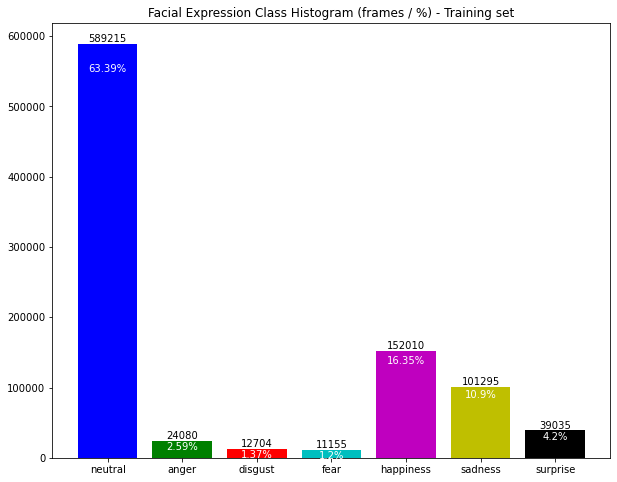

In [271]:
AW2_train_highlevel_dist = {i: 0 for i in names_class}
for ann_file in AW2_train_FN:
    values = AW2_train_classdist.get(ann_file)
    for name in AW2_train_highlevel_dist.keys():
        AW2_train_highlevel_dist[name] += values.get(name)

AW2_distplotter(AW2_train_highlevel_dist, "Facial Expression Class Histogram (frames / %) - Training set")

### Validation set: Facial Expression Class distribution

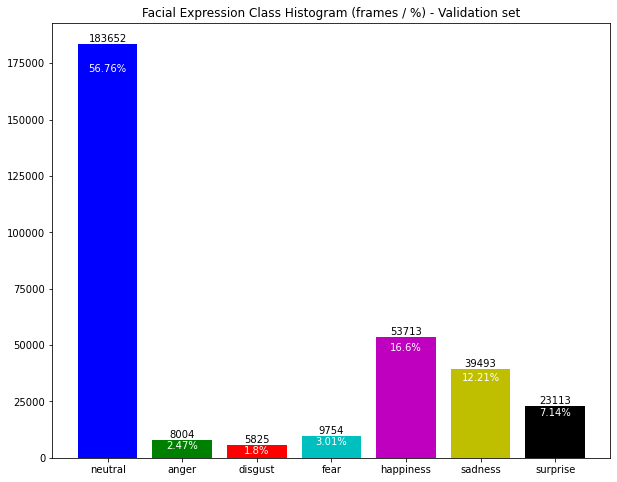

In [270]:
AW2_val_highlevel_dist = {i: 0 for i in names_class}
for ann_file in AW2_val_FN:
    values = AW2_val_classdist.get(ann_file)
    for name in AW2_val_highlevel_dist.keys():
        AW2_val_highlevel_dist[name] += values.get(name)
        
AW2_distplotter(AW2_val_highlevel_dist, "Facial Expression Class Histogram (frames / %) - Validation set")